# DeepLense projects - Common Test 1 - Multi-Class Classification

## Imports and Configs

In [1]:
# Imports
from collections import Counter
from functools import partial
from pathlib import Path

# Importing self-defined functions and classes from another notebook
from Modules.NbLoader import *

FUNC_CLASSES_PATH = Path.cwd() / "Modules" / "Functions-Classes.ipynb"
functions_classes = NotebookLoader(path=FUNC_CLASSES_PATH).load_module(
    "functions_classes"
)

import torch
from functions_classes import *
from joblib import dump, load
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from torchvision.transforms import Normalize

importing Jupyter notebook from /home2/nouduru.venkata/GSOC/NVR-ML4SCI-GSOC24/DeepLense Tests/Codes/Modules/Functions-Classes.ipynb


In [2]:
# Configs
LABEL_MAP = {"vort": 0, "sphere": 1, "no": 2}

# Save bools
SAVE_METRICS: bool = False
SAVE_MODELS: bool = False
SAVE_PLOTS: bool = False

# Data Configs
SCALE_OUTPUTS: bool = False
BATCH_SIZE: int = 256
SHUFFLE_LOADING: bool = True

# Training Configs
N_EPOCHS = 30

# Torch configs
torch.set_default_dtype(torch.float64)

## Data Loading and Exploration

In [3]:
# Defining relative paths
CWD = Path.cwd()
DATA_FOLDER = CWD.parent / "Datasets" / "ct1"
OUTPUTS = CWD.parent / "Outputs" / "ct1"

OUTPUTS.mkdir(parents=True, exist_ok=True)

# Loading paths
LOAD_MODELS = Path.cwd()
LOAD_WEIGHTS = Path.cwd()

In [4]:
# Sorting file paths into train and val files
ALL_FILES = list(DATA_FOLDER.rglob("*.npy"))
TRAIN_FILES = list(filter(lambda x: x.parents[1].name == "train", ALL_FILES))
VAL_FILES = list(filter(lambda x: x.parents[1].name == "val", ALL_FILES))

In [5]:
# Defining DataLoaders using custom dataset class
transform = Normalize(0, 1)
trainset = CT1Set(
    file_paths=TRAIN_FILES,
    label_map=LABEL_MAP,
    transform=transform,
    target_transform=None,
)
valset = CT1Set(
    file_paths=VAL_FILES,
    label_map=LABEL_MAP,
    transform=transform,
    target_transform=None,
)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_LOADING)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_LOADING)

In [6]:
# Data Statistics
classes = list(LABEL_MAP.keys())
train_names = list(map(lambda x: x.parent.name, TRAIN_FILES))
val_names = list(map(lambda x: x.parent.name, VAL_FILES))

train_counts = Counter(train_names)
val_counts = Counter(val_names)

print(
    "".join(["="] * 20) + " Dataset statistics for Common Test 1 " + "".join(["="] * 20)
)
print("Distribution of Train images:")
print(train_counts)
print("\n")
print("Distribution of Validation (Test) images:")
print(val_counts)

==================== Dataset statistics for Common Test 1 ====================
Distribution of Train images:
Counter({'vort': 10000, 'no': 10000, 'sphere': 10000})


Distribution of Validation (Test) images:
Counter({'vort': 2500, 'no': 2500, 'sphere': 2500})


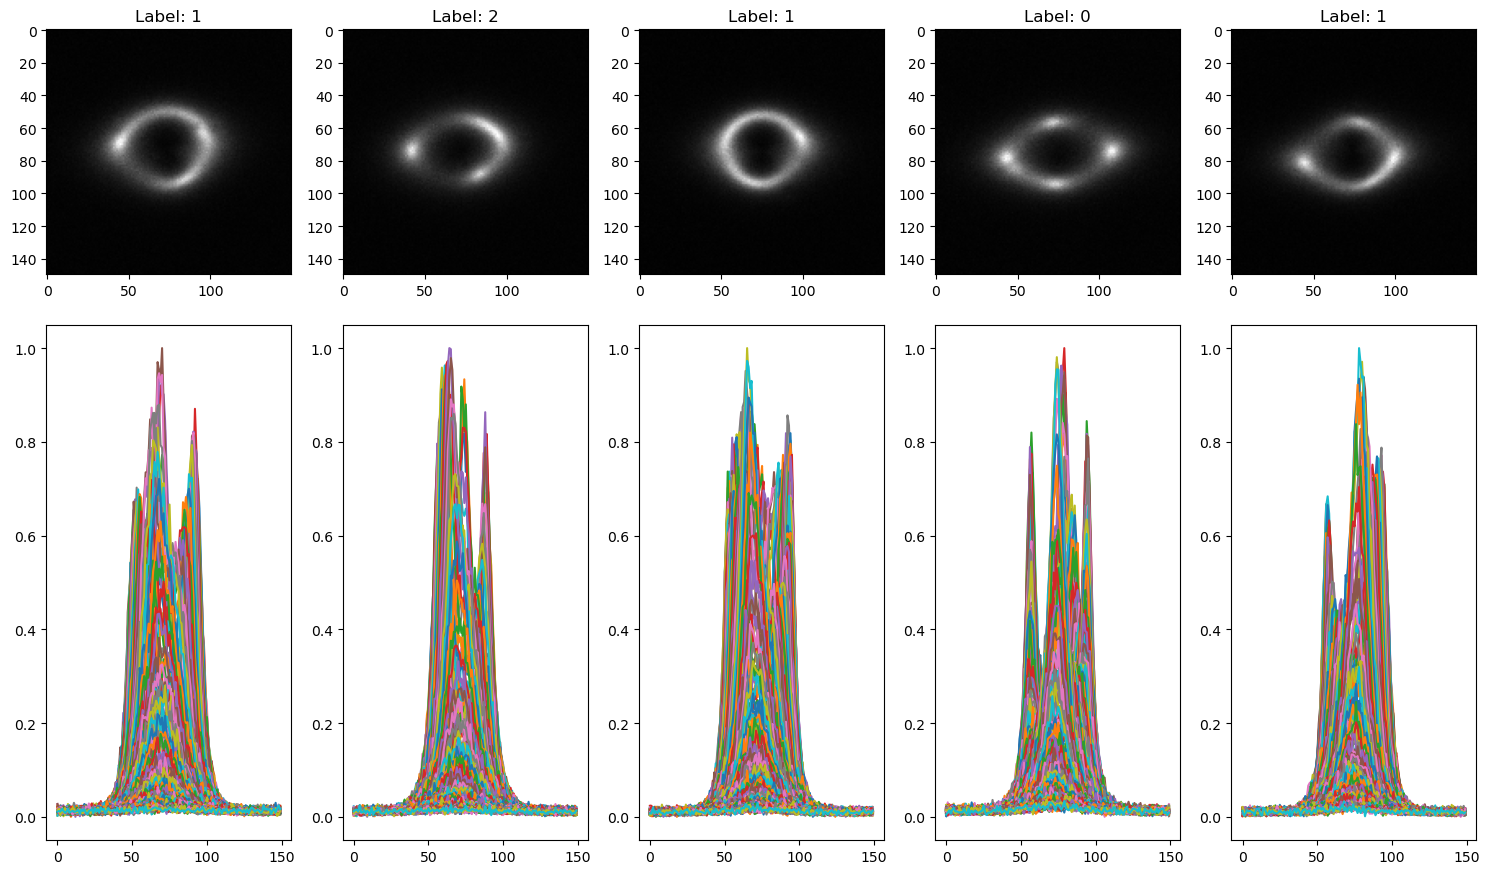

In [7]:
# Displaying random images from train data
random_plots(trainset)

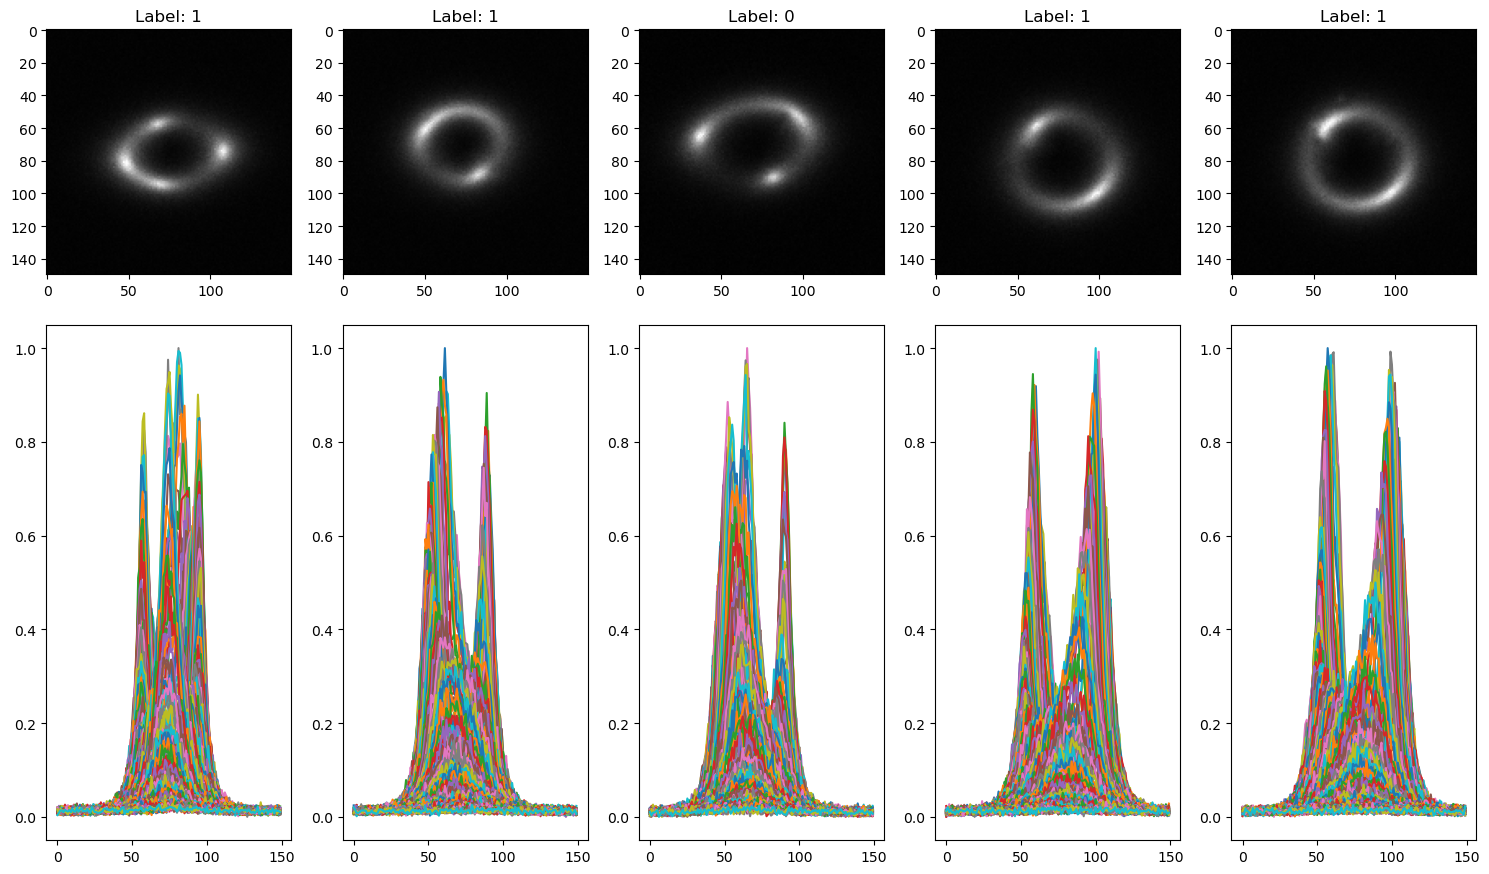

In [8]:
# Displaying random images from val data
random_plots(valset)

## Model Training and Testing

In [10]:
# Model Class definitions
# CNN 1
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 3),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        out = self.model(x)
        return out


# Preparing ResNet 18 from PyTorch
resnet = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True)


class mod_resnet(nn.Module):
    def __init__(self, pre_trained_resnet):
        super().__init__()
        self.cn1 = nn.Conv2d(1, 3, 5, 1, 2)
        self.pre_trained = pre_trained_resnet
        self.fc_last = nn.Linear(pre_trained_resnet.fc.out_features, 3)

    def forward(self, x):
        x = self.first_conv(x)
        x = self.pre_trained(x)
        out = self.last_lin(x)
        return out


# Metrics dictionary
metrics_dict = {
    "f1_score": metrics.f1_score,
    "accuracy": metrics.accuracy_score,
    "precision": metrics.precision_score,
    "recall": metrics.recall_score,
}

metric_args = {
    "f1_score": {"average": "macro"},
    "accuracy": None,
    "precision": {"average": "macro"},
    "recall": {"average": "macro"},
}

metrics_dict_partials = {
    sname: (partial(score, **metric_args[sname]) if metric_args[sname] else score)
    for sname, score in metrics_dict.items()
}

Using cache found in /home2/nouduru.venkata/.cache/torch/hub/pytorch_vision_v0.10.0
/home2/nouduru.venkata/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/nouduru.venkata/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Training models

# CNN
# model = CNN1()
# model = mod_resnet(resnet)

# Model prep - For resnet only
# for name, param in model.named_parameters():
#     if ('fc' in name) or ('cn1' in name):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# model_optim = optim(model)
# criterion = nn.CrossEntropyLoss()

# trained_model, train_loss, _ = modeltrainer(
#     model,
#     optimizer=model_optim,
#     trainloader=trainloader,
#     epochs=N_EPOCHS,
#     criterion=criterion,
# )

# Saving state dict
# torch.save(model.state_dict(), OUTPUTS / f"CNN1_{N_EPOCHS}eps.pth")
# torch.save(model.state_dict(), OUTPUTS / f"ResNet18_{N_EPOCHS}eps.pth")
# dump(train_loss, OUTPUTS / f"CNN1_trainloss_{N_EPOCHS}eps.joblib")
# dump(train_loss, OUTPUTS / f"ResNet18_trainloss_{N_EPOCHS}eps.joblib")

# Temporary joblib based saving
# dump(trained_model, "trained_cnn1_75ep.joblib")

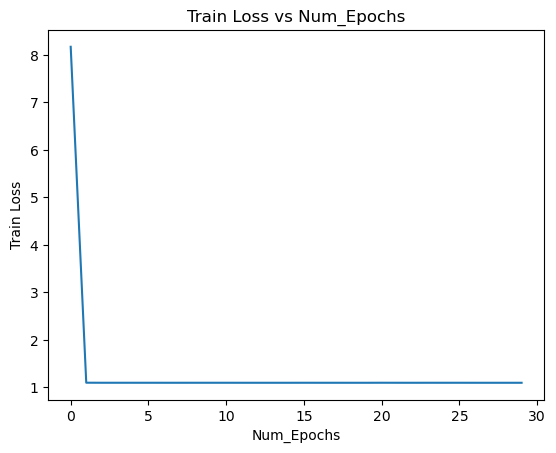

In [57]:
# Plotting loss vs Number of Epochs
# plt.plot(range(N_EPOCHS), train_loss)
# plt.title("Train Loss vs Num_Epochs")
# plt.ylabel("Train Loss")
# plt.xlabel("Num_Epochs")
# plt.show()

In [11]:
# # Loading models
# model = CNN1()
# # model = mod
# model.load_state_dict(torch.load(OUTPUTS / f"CNN1_{N_EPOCHS}eps.pth"))
# train_loss = load("cnn1_trainloss_75ep.joblib")

# # Temporary Joblib loading
# # trained_model = load("trained_cnn1_75ep.joblib")

  0%|          | 0/30 [00:00<?, ?it/s]

({'CNN1': {'f1_score': 0.32441834791529595,
   'accuracy': 0.3428,
   'precision': 0.3442565697521241,
   'recall': 0.3428,
   'AUC_ROC': 0.51235968,
   'ROC_Curve': (<Figure size 640x480 with 3 Axes>,
    array([<Axes: title={'center': 'ROC Curve for Class 0'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
           <Axes: title={'center': 'ROC Curve for Class 1'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
           <Axes: title={'center': 'ROC Curve for Class 2'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>],
          dtype=object))}},
 {'CNN1': array([0, 1, 0, ..., 0, 2, 2])},
 {'CNN1': array([[0.33853151, 0.33077085, 0.33069764],
         [0.33402382, 0.33861484, 0.32736134],
         [0.33750688, 0.33286082, 0.3296323 ],
         ...,
         [0.34694894, 0.32807542, 0.32497565],
         [0.33348968, 0.33071148, 0.33579884],
         [0.31529657, 0.33445868, 0.35024474]])})

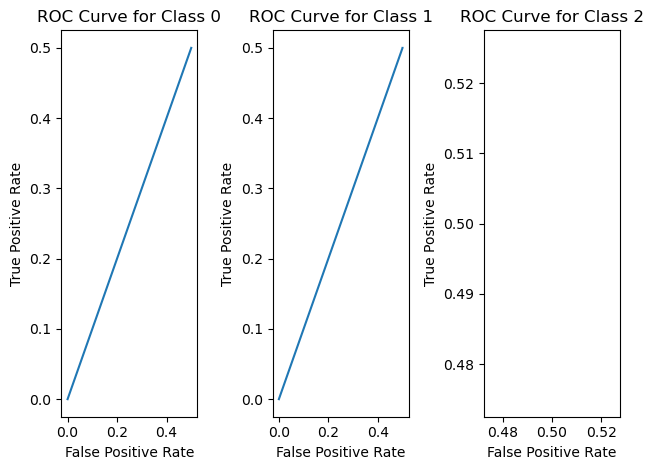

In [ ]:
# # Testing models
# trained_models = {"CNN1": (model, train_loss)}
# metrictester(
#     pt_trained=trained_models,
#     metric_dict=metrics_dict_partials,
#     ROC_AUC=True,
#     testloader=valloader,
#     multi_class=True,
#     last_activation=nn.Softmax(dim=1),
#     save_metrics=SAVE_METRICS,
#     save_path=OUTPUTS,
#     save_name="CT1 - CNN",
# )

# Model Training and Testing (PyTorch Lightning)

In [ ]:
import os
import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

%matplotlib inline
from IPython.display import HTML, display
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from PIL import Image
from torchvision import transforms
# from torchvision.datasets import CIFAR10

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# PyTorch
# Torchvision

In [ ]:
class CTModule(L.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 1, 150, 150), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

In [ ]:
def train_model(model_name, save_name=None, **kwargs):
    """Train model.

    Args:
        model_name: Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional): If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        # How many epochs to train for if no patience is set
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CTModule.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducible
        model = CTModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CTModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [ ]:
class LCNN1(L.LightningModule):